In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleResourceGame:
    def __init__(self, max_steps=100):
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.resources = 10
        self.step_count = 0
        self.done = False
        return self._get_state()

    def step(self, action):
        old_resources = self.resources
        
        # Action: 0 = Save, 1 = Spend
        if action == 1:  # Spend
            if self.resources > 0:
                self.resources += np.random.randint(0, 1000)
                self.resources -= 1
            else:
                self.resources -= 1
        else:  # Save
            self.resources += 1

        self.step_count += 1
        if self.step_count >= self.max_steps:
            self.done = True

        # Calculate the change in resources
        resource_change = self.resources - old_resources

        return self._get_state(), resource_change, self.done, {}

    def _get_state(self):
        return np.array([self.resources, self.step_count])

    def render(self):
        print(f"Step: {self.step_count}, Resources: {self.resources}")

Parameter containing:
tensor([[-0.2475, -0.1935],
        [-0.4360,  0.0338]], requires_grad=True) Parameter containing:
tensor([ 0.6370, -0.3985], requires_grad=True)


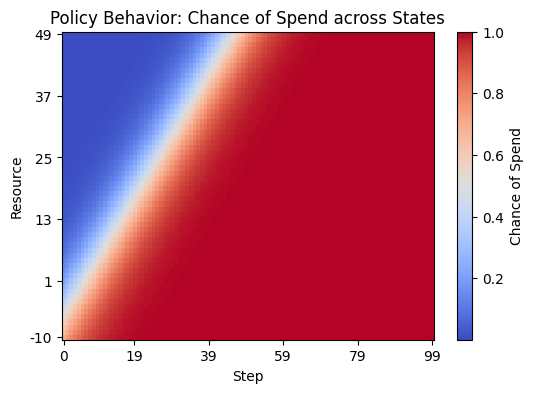

In [127]:
from SimplePolicy import SimplePolicy
import torch
import torch.nn as nn

torch.manual_seed(72)
simplePolicy = SimplePolicy(2, 2)
print(simplePolicy.fc.weight, simplePolicy.fc.bias)
simplePolicy.plot_policy_heatmap()

In [128]:
game = SimpleResourceGame

In [154]:
def sample_trajectories(policy, n=10, max_step=10):
    trajectories = []

    for _ in range(n):
        trajectory = []
        env = game() 
        state = env.reset()
        done = False
        step = 0

        while (not done) and (step < max_step):
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()

            next_state, reward, done, _ = env.step(action.item())

            trajectory.append((state, action.item(), reward))

            state = next_state
            step += 1
        trajectories.append(trajectory)
    return trajectories

def get_trajectories_mean(trajectories):
    resources = [[step[0][0] for step in trajectory] for trajectory in trajectories]
    return np.mean(np.array(resources)), np.std(np.array(resources))

In [155]:
def plot_rewards(trajectories):
    time = np.arange(len(trajectories[0]))
    n = len(trajectories)

    resources = [[step[0][0] for step in trajectory] for trajectory in trajectories]
    actions = [[step[1] for step in trajectory] for trajectory in trajectories]
    
    plt.figure(figsize=(10, 6))
    for resource in resources:
        plt.plot(time, resource, alpha=0.1, color='#1f77b4')

    for resource, action in zip(resources, actions):
        for i, (x, y, a) in enumerate(zip(time, resource, action)):
            if a == 1:
                plt.plot(x, y, 's', markersize=5, color='red', alpha = 0.1)
            if a == 0:
                plt.plot(x, y, '-o', markersize=5, alpha= 0.1, color='#1f77b4')
            # if i > 0:  # Skip labeling the initial state
            #     plt.annotate(action, (x, y), xytext=(5, 5), textcoords='offset points')

    plt.xlabel('Time')
    plt.ylabel('Resources')
    plt.title('Resource Over Time')
    plt.grid(True)
    plt.show()

    # Print final state
    print(f"Final state - Time: {time[-1]}, Resources: {resources[-1]}")

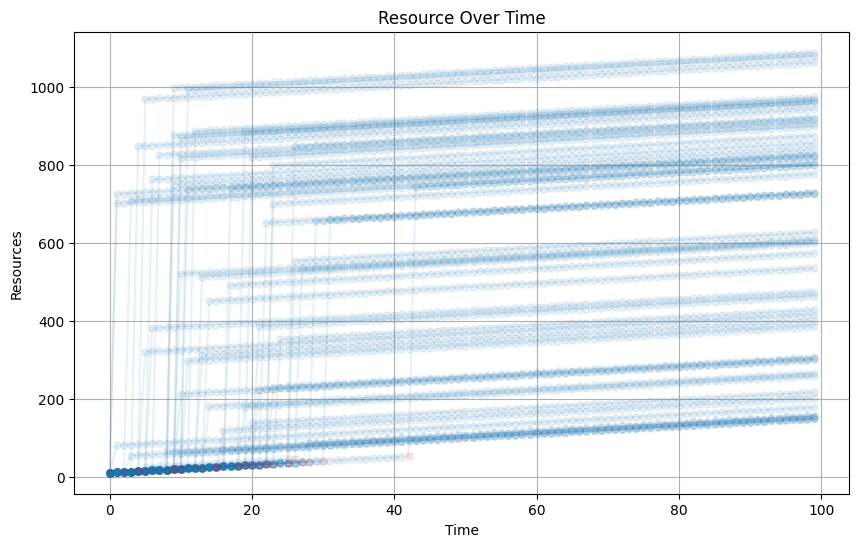

Final state - Time: 99, Resources: [10, 11, 12, 13, 14, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062]
(496.119, 341.5020597873459)


In [156]:
trajectories = sample_trajectories(simplePolicy, n=50, max_step=100)
plot_rewards(trajectories)
print(get_trajectories_mean(trajectories))

In [157]:
def get_loss_for_trajectory(trajectories, action_logs):
    def discount_rewards(trajectory, gamma=0.9):
        rewards = [t[2] for t in trajectory]
        discounted_rewards = torch.zeros_like(torch.tensor(rewards, dtype=torch.float32))
        R = 0
        for t in reversed(range(len(rewards))):
            R = rewards[t] + gamma * R
            discounted_rewards[t] = R
        return discounted_rewards

    losses = []
    for trajectory, action_log in zip(trajectories, action_logs):
        discounted_rewards = discount_rewards(trajectory)
        
        min_len = min(len(action_log), len(discounted_rewards))
        action_log = action_log[:min_len]
        discounted_rewards = discounted_rewards[:min_len]
        
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
        
        episode_loss = -1 * (action_log * discounted_rewards).sum()
        losses.append(episode_loss)

    return torch.stack(losses).mean()

def reinforce(policy, optimizer, n=10):
    trajectories = []
    action_logs = []

    for _ in range(n):
        trajectory = []
        env = game()  # Assuming game() is defined elsewhere
        state = env.reset()
        episode_action_logs = []

        done = False
        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)

            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)

            next_state, reward, done, _ = env.step(action.item())

            trajectory.append((state, action.item(), reward))
            episode_action_logs.append(log_prob)

            state = next_state

        trajectories.append(trajectory)
        action_logs.append(torch.stack(episode_action_logs))

    loss = get_loss_for_trajectory(trajectories, action_logs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Parameter containing:
tensor([[-0.2475, -0.1935],
        [-0.4360,  0.0338]], requires_grad=True) Parameter containing:
tensor([ 0.6370, -0.3985], requires_grad=True)


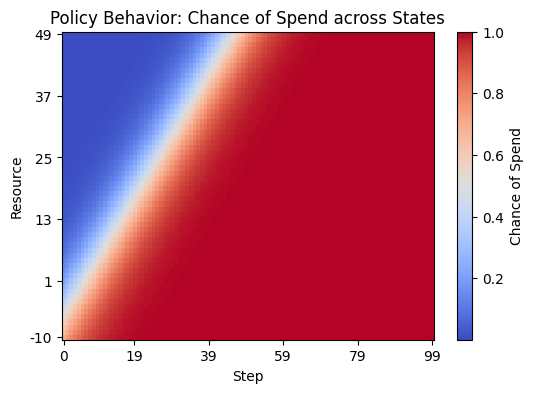

Epoch 0, Loss: 12.229949951171875
Epoch 1, Loss: 13.791836738586426
Epoch 2, Loss: 12.577359199523926
Epoch 3, Loss: 11.781925201416016
Epoch 4, Loss: 15.115127563476562
Epoch 5, Loss: 14.649482727050781
Epoch 6, Loss: 11.965574264526367
Epoch 7, Loss: 11.889604568481445
Epoch 8, Loss: 17.826953887939453
Epoch 9, Loss: 15.771528244018555
Epoch 10, Loss: 22.687156677246094
Epoch 11, Loss: 0.8470367193222046
Epoch 12, Loss: -0.34990811347961426
Epoch 13, Loss: 0.41098862886428833
Epoch 14, Loss: -0.13679012656211853
Epoch 15, Loss: -0.5943067669868469
Epoch 16, Loss: 0.3266676068305969
Epoch 17, Loss: 0.06777532398700714
Epoch 18, Loss: 0.21360866725444794
Epoch 19, Loss: 0.20205314457416534
Epoch 20, Loss: -0.02650408074259758
Epoch 21, Loss: 0.17681840062141418
Epoch 22, Loss: 0.13370585441589355
Epoch 23, Loss: 0.28879839181900024
Epoch 24, Loss: -0.10579462349414825
Epoch 25, Loss: -0.08469431847333908
Epoch 26, Loss: 0.07836108654737473
Epoch 27, Loss: 0.15525147318840027
Epoch 28, 

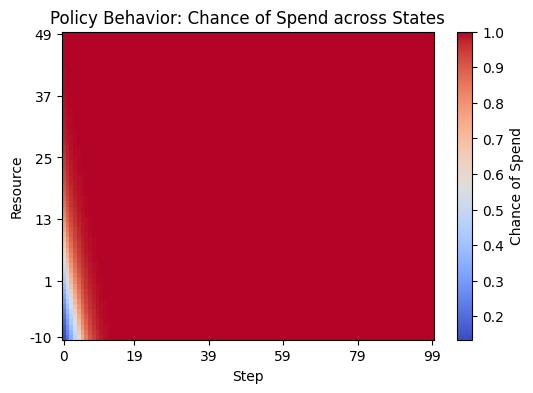

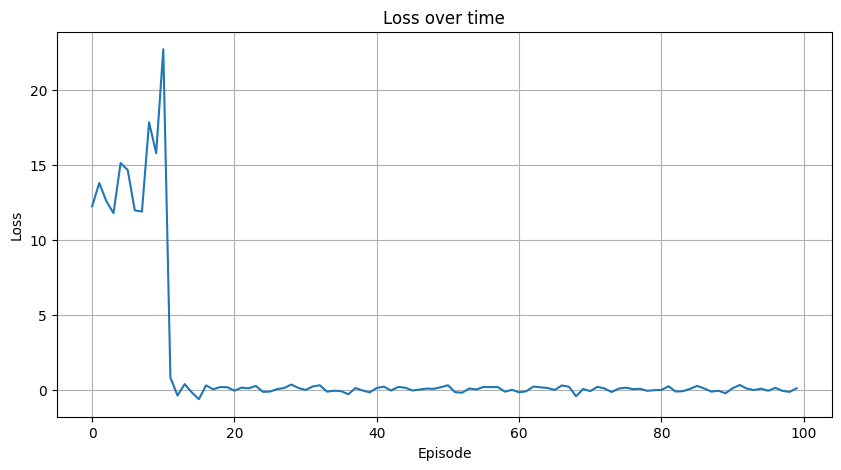

In [158]:
torch.manual_seed(72)

trainPolicy = SimplePolicy(2, 2)
print(trainPolicy.fc.weight, trainPolicy.fc.bias)
trainPolicy.plot_policy_heatmap()
optimizer = optim.Adam(trainPolicy.parameters(), lr=0.01)

losses = []
for epoch in range(100):  # Run for 100 episodes
    loss = reinforce(trainPolicy, optimizer)
    losses.append(loss)
    print(f"Epoch {epoch}, Loss: {loss}")

trainPolicy.plot_policy_heatmap()

# Plot the losses
plot_loss(losses)

(24357.3242, 14465.76422344476)


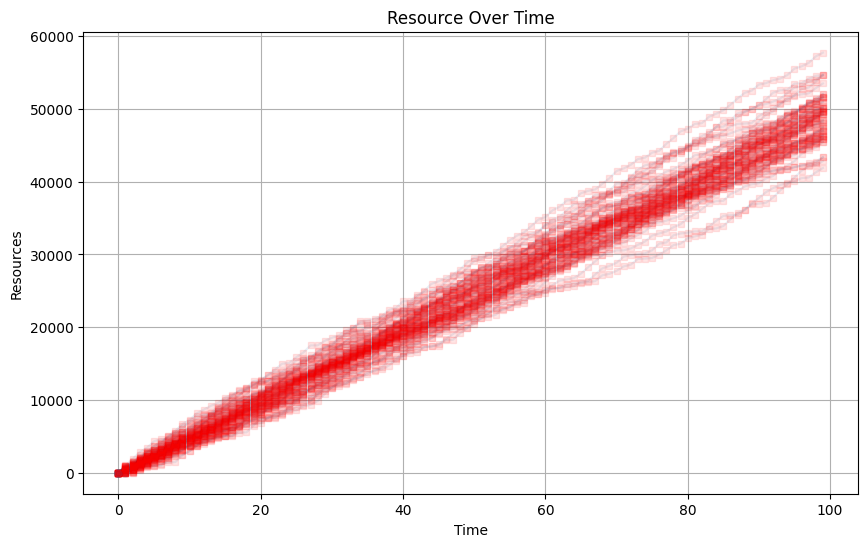

Final state - Time: 99, Resources: [10, 723, 1171, 2092, 3015, 3675, 4089, 5060, 5761, 6708, 7258, 8166, 8662, 9204, 9584, 10333, 10709, 11232, 11313, 12017, 12748, 13457, 14177, 14981, 15075, 15881, 16527, 17502, 17506, 18129, 18538, 18878, 19570, 19944, 20541, 20561, 20805, 21449, 21676, 22274, 22354, 23050, 23805, 23848, 24617, 25272, 25495, 25650, 26101, 26359, 26859, 27213, 27724, 28709, 29616, 29867, 30014, 30504, 31286, 32233, 32876, 33833, 34040, 35029, 35299, 36120, 37034, 37610, 37969, 38377, 38636, 39546, 40077, 41045, 41530, 42275, 42856, 43556, 44114, 44217, 44883, 44896, 45561, 46175, 46195, 46286, 46648, 47000, 47275, 47404, 48236, 49196, 49647, 50619, 51486, 51821, 51999, 52127, 52851, 53488]


In [159]:
trajectories = sample_trajectories(trainPolicy, n=50, max_step=100)
print(get_trajectories_mean(trajectories))
plot_rewards(trajectories)

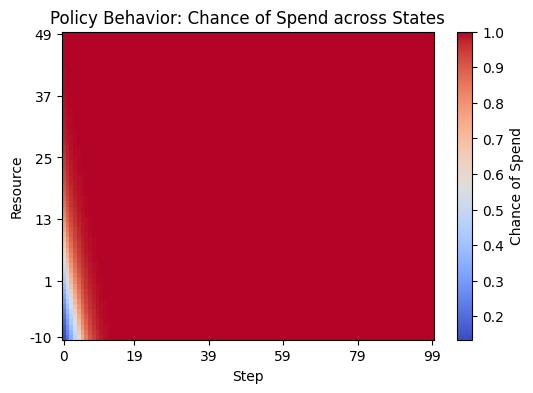

In [160]:
trainPolicy.plot_policy_heatmap()

[10  0]


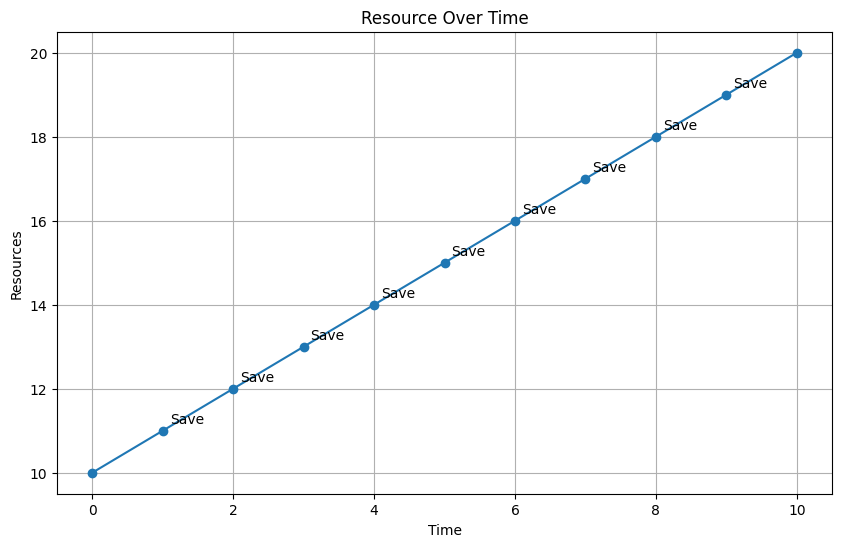

Final state - Time: 10, Resources: 20


In [105]:
# Example usage
for t in range(1, 11):  # Run for 10 steps
    state = torch.FloatTensor(state)
    sampled_action = torch.multinomial(simplePolicy(state), num_samples=1).item()
    state, reward, done, _ = env.step(sampled_action)
    resources.append(state[0])
    times.append(t)
    actions.append('Spend' if sampled_action == 1 else 'Save')
    if done:
        break

plot_rewards(times, resources, actions)

In [106]:
import torch.optim as optim

def train_policy(env, episodes=1000, lr=0.01):
    input_dim = 2  # resources and step_count
    output_dim = 2  # save or spend
    policy = SimplePolicy(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, num_samples=1).item()
            
            next_state, reward, done, _ = env.step(action)
            
            episode_reward = next_state[0]
            print(f"state: {state}, reward: {reward}")
            
            # Compute loss and update policy
            loss = -1 * torch.log(action_probs[action]) * reward
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            state = next_state
            
            if done:
                break
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")
            policy.plot_policy_heatmap()
        # elif episode + 1 < 10:
        #     policy.plot_policy_heatmap()
        #     print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return policy

state: [10  0], reward: 0
state: [10  1], reward: 1
state: [11  2], reward: 1
state: [12  3], reward: 3
state: [15  4], reward: 2
state: [17  5], reward: 1
state: [18  6], reward: 0
state: [18  7], reward: 1
state: [19  8], reward: -1
state: [18  9], reward: 0
state: [18 10], reward: 2
state: [20 11], reward: 1
state: [21 12], reward: 0
state: [21 13], reward: 1
state: [22 14], reward: -1
state: [21 15], reward: 0
state: [21 16], reward: 3
state: [24 17], reward: 2
state: [26 18], reward: 0
state: [26 19], reward: 0
state: [26 20], reward: 1
state: [27 21], reward: 0
state: [27 22], reward: 1
state: [28 23], reward: 0
state: [28 24], reward: 3
state: [31 25], reward: 3
state: [34 26], reward: 1
state: [35 27], reward: -1
state: [34 28], reward: -1
state: [33 29], reward: 3
state: [36 30], reward: 3
state: [39 31], reward: 0
state: [39 32], reward: -1
state: [38 33], reward: 2
state: [40 34], reward: 1
state: [41 35], reward: 3
state: [44 36], reward: 0
state: [44 37], reward: 2
state: 

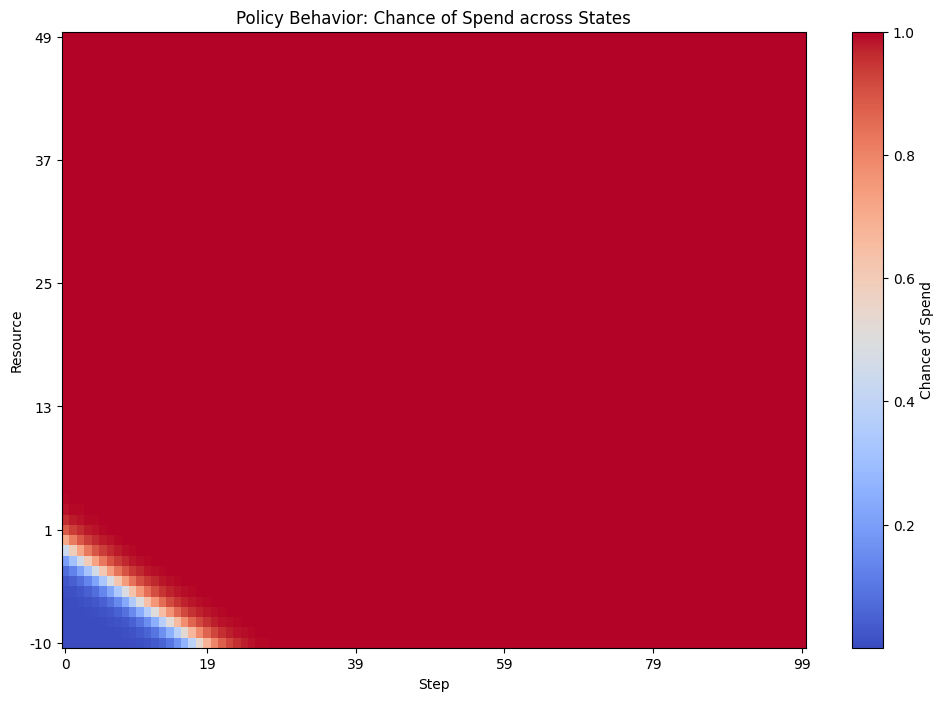

state: [10  0], reward: 0
state: [10  1], reward: -1
state: [9 2], reward: 0
state: [9 3], reward: -1
state: [8 4], reward: 3
state: [11  5], reward: -1
state: [10  6], reward: 3
state: [13  7], reward: 0
state: [13  8], reward: 1
state: [14  9], reward: 0
state: [14 10], reward: -1
state: [13 11], reward: -1
state: [12 12], reward: -1
state: [11 13], reward: -1
state: [10 14], reward: -1
state: [ 9 15], reward: 3
state: [12 16], reward: 1
state: [13 17], reward: 3
state: [16 18], reward: 2
state: [18 19], reward: 2
state: [20 20], reward: 0
state: [20 21], reward: 0
state: [20 22], reward: 2
state: [22 23], reward: 2
state: [24 24], reward: 0
state: [24 25], reward: 2
state: [26 26], reward: 0
state: [26 27], reward: 1
state: [27 28], reward: 2
state: [29 29], reward: 2
state: [31 30], reward: 3
state: [34 31], reward: 1
state: [35 32], reward: 2
state: [37 33], reward: 2
state: [39 34], reward: 1
state: [40 35], reward: 3
state: [43 36], reward: 1
state: [44 37], reward: 3
state: [47

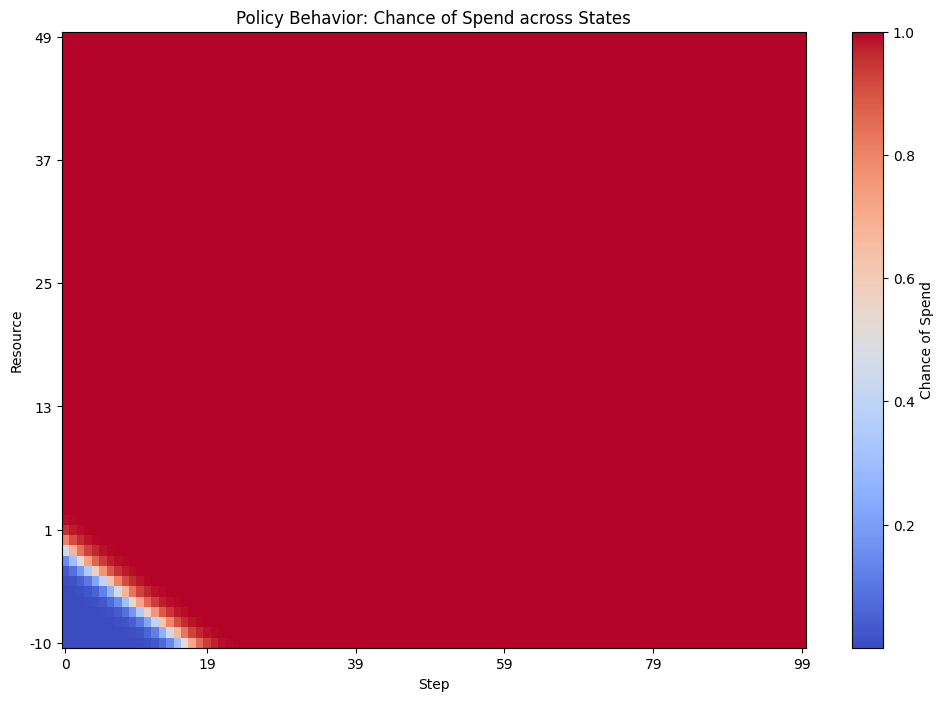

state: [10  0], reward: 3
state: [13  1], reward: 2
state: [15  2], reward: 1
state: [16  3], reward: 1
state: [17  4], reward: 1
state: [18  5], reward: 0
state: [18  6], reward: 0
state: [18  7], reward: 2
state: [20  8], reward: -1
state: [19  9], reward: 2
state: [21 10], reward: 1
state: [22 11], reward: 0
state: [22 12], reward: 0
state: [22 13], reward: 2
state: [24 14], reward: 2
state: [26 15], reward: 0
state: [26 16], reward: 1
state: [27 17], reward: 3
state: [30 18], reward: 2
state: [32 19], reward: -1
state: [31 20], reward: -1
state: [30 21], reward: -1
state: [29 22], reward: 1
state: [30 23], reward: 2
state: [32 24], reward: -1
state: [31 25], reward: 1
state: [32 26], reward: 0
state: [32 27], reward: 3
state: [35 28], reward: 2
state: [37 29], reward: -1
state: [36 30], reward: 2
state: [38 31], reward: 3
state: [41 32], reward: 0
state: [41 33], reward: 0
state: [41 34], reward: 2
state: [43 35], reward: 2
state: [45 36], reward: 1
state: [46 37], reward: -1
state

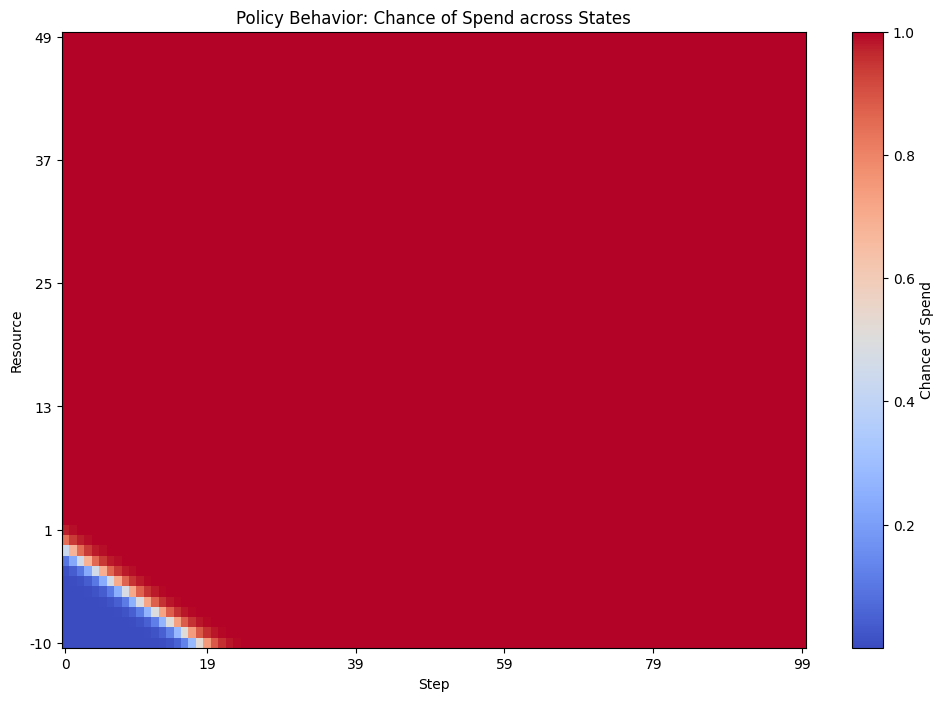

state: [10  0], reward: -1
state: [9 1], reward: 0
state: [9 2], reward: 2
state: [11  3], reward: 0
state: [11  4], reward: 3
state: [14  5], reward: 3
state: [17  6], reward: 0
state: [17  7], reward: 0
state: [17  8], reward: 3
state: [20  9], reward: 3
state: [23 10], reward: 3
state: [26 11], reward: -1
state: [25 12], reward: -1
state: [24 13], reward: 1
state: [25 14], reward: 3
state: [28 15], reward: 3
state: [31 16], reward: -1
state: [30 17], reward: -1
state: [29 18], reward: 1
state: [30 19], reward: 1
state: [31 20], reward: 1
state: [32 21], reward: -1
state: [31 22], reward: 0
state: [31 23], reward: 2
state: [33 24], reward: -1
state: [32 25], reward: 0
state: [32 26], reward: -1
state: [31 27], reward: 3
state: [34 28], reward: 3
state: [37 29], reward: -1
state: [36 30], reward: 0
state: [36 31], reward: 1
state: [37 32], reward: 0
state: [37 33], reward: 2
state: [39 34], reward: -1
state: [38 35], reward: -1
state: [37 36], reward: 2
state: [39 37], reward: 1
state

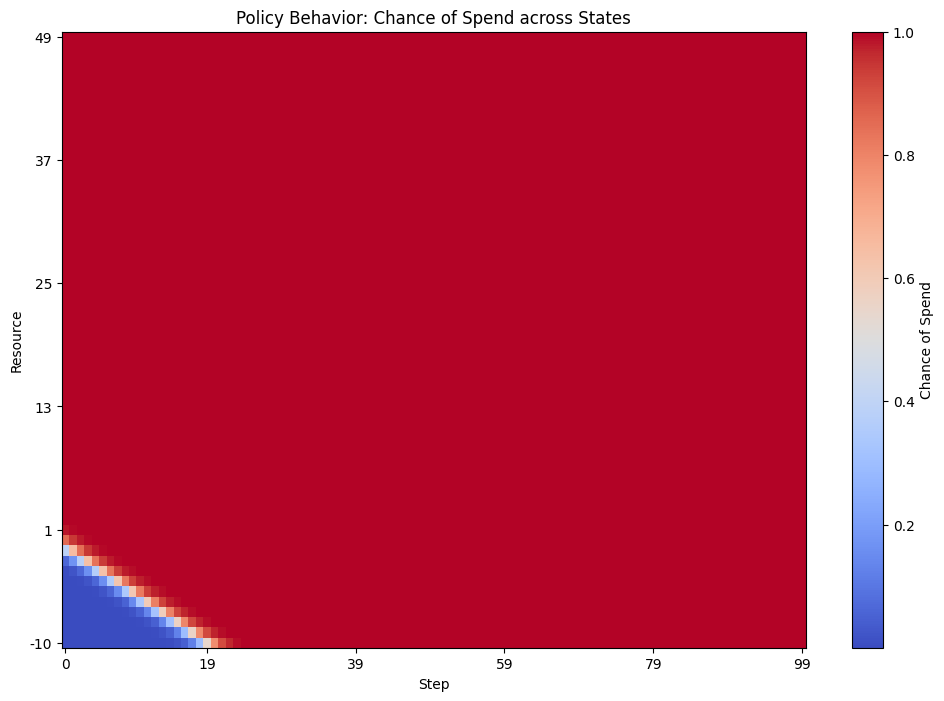

state: [10  0], reward: 1
state: [11  1], reward: 1
state: [12  2], reward: 0
state: [12  3], reward: 3
state: [15  4], reward: 0
state: [15  5], reward: 1
state: [16  6], reward: 0
state: [16  7], reward: 0
state: [16  8], reward: 0
state: [16  9], reward: 0
state: [16 10], reward: 3
state: [19 11], reward: 3
state: [22 12], reward: 2
state: [24 13], reward: -1
state: [23 14], reward: 0
state: [23 15], reward: 0
state: [23 16], reward: 1
state: [24 17], reward: 0
state: [24 18], reward: 3
state: [27 19], reward: 3
state: [30 20], reward: 1
state: [31 21], reward: 0
state: [31 22], reward: -1
state: [30 23], reward: 2
state: [32 24], reward: 3
state: [35 25], reward: -1
state: [34 26], reward: 1
state: [35 27], reward: 2
state: [37 28], reward: 2
state: [39 29], reward: -1
state: [38 30], reward: 2
state: [40 31], reward: 0
state: [40 32], reward: 0
state: [40 33], reward: 2
state: [42 34], reward: 0
state: [42 35], reward: 1
state: [43 36], reward: 1
state: [44 37], reward: 3
state: [

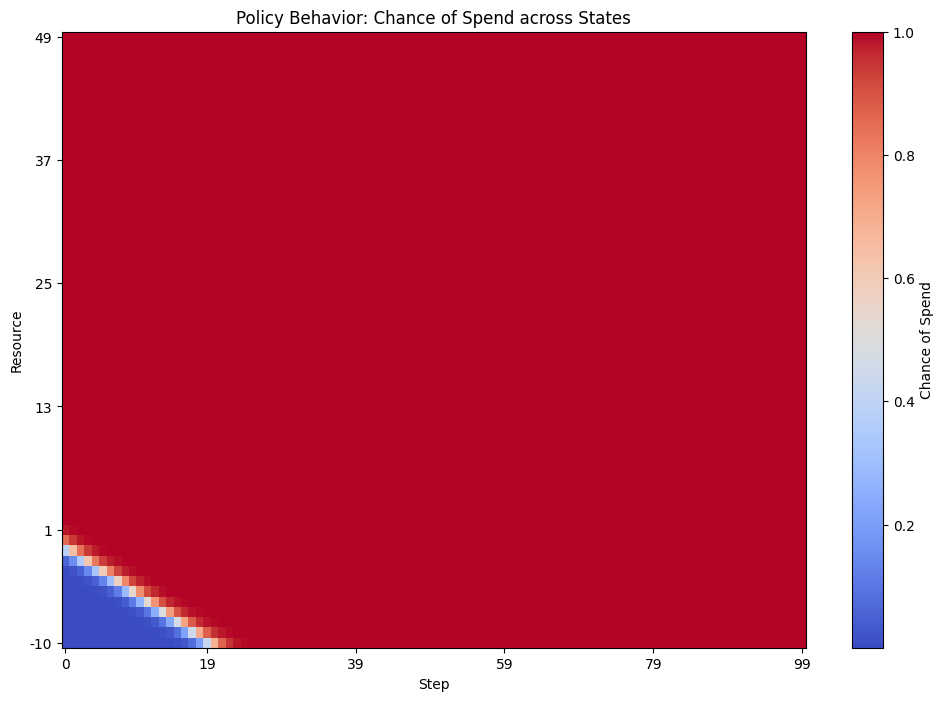

state: [10  0], reward: 3
state: [13  1], reward: -1
state: [12  2], reward: 3
state: [15  3], reward: 3
state: [18  4], reward: 1
state: [19  5], reward: 3
state: [22  6], reward: 0
state: [22  7], reward: -1
state: [21  8], reward: 1
state: [22  9], reward: -1
state: [21 10], reward: 1
state: [22 11], reward: 0
state: [22 12], reward: 1
state: [23 13], reward: 1
state: [24 14], reward: 1
state: [25 15], reward: 1
state: [26 16], reward: 1
state: [27 17], reward: 1
state: [28 18], reward: 1
state: [29 19], reward: 3
state: [32 20], reward: 1
state: [33 21], reward: 2
state: [35 22], reward: 0
state: [35 23], reward: 1
state: [36 24], reward: -1
state: [35 25], reward: 3
state: [38 26], reward: 1
state: [39 27], reward: -1
state: [38 28], reward: 0
state: [38 29], reward: 2
state: [40 30], reward: 3
state: [43 31], reward: -1
state: [42 32], reward: 1
state: [43 33], reward: 2
state: [45 34], reward: 3
state: [48 35], reward: 2
state: [50 36], reward: 3
state: [53 37], reward: 2
state:

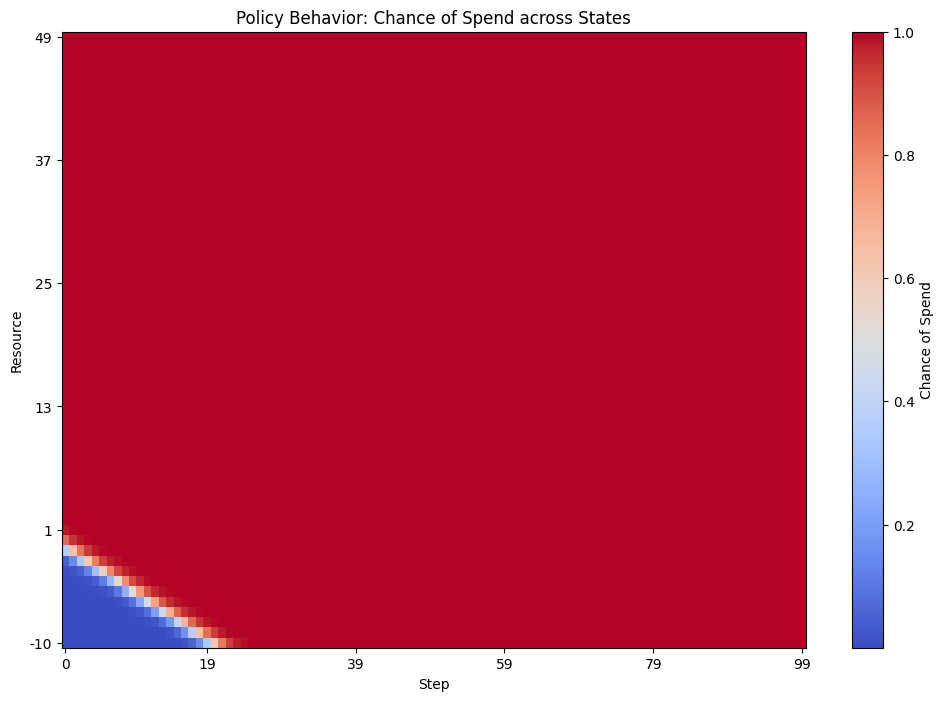

state: [10  0], reward: 0
state: [10  1], reward: 3
state: [13  2], reward: 0
state: [13  3], reward: 0
state: [13  4], reward: 3
state: [16  5], reward: -1
state: [15  6], reward: 2
state: [17  7], reward: 3
state: [20  8], reward: -1
state: [19  9], reward: 1
state: [20 10], reward: 2
state: [22 11], reward: 2
state: [24 12], reward: 3
state: [27 13], reward: -1
state: [26 14], reward: 3
state: [29 15], reward: 0
state: [29 16], reward: 2
state: [31 17], reward: -1
state: [30 18], reward: 1
state: [31 19], reward: -1
state: [30 20], reward: 2
state: [32 21], reward: -1
state: [31 22], reward: 0
state: [31 23], reward: 0
state: [31 24], reward: 2
state: [33 25], reward: 1
state: [34 26], reward: -1
state: [33 27], reward: 3
state: [36 28], reward: 2
state: [38 29], reward: 3
state: [41 30], reward: 1
state: [42 31], reward: 3
state: [45 32], reward: -1
state: [44 33], reward: 2
state: [46 34], reward: 0
state: [46 35], reward: 3
state: [49 36], reward: 1
state: [50 37], reward: 3
stat

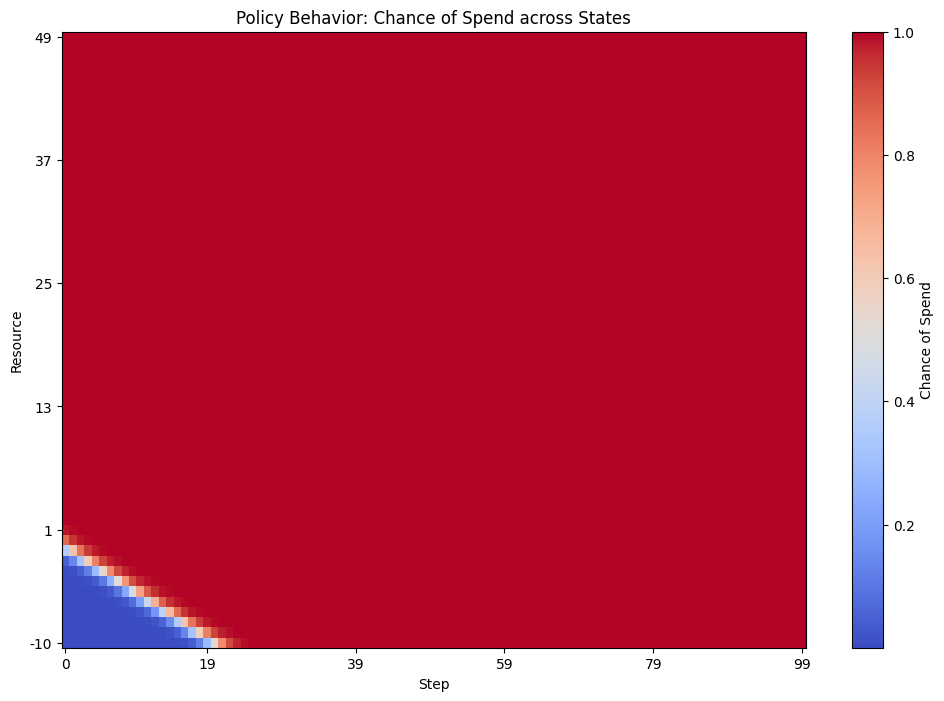

state: [10  0], reward: 0
state: [10  1], reward: 3
state: [13  2], reward: 0
state: [13  3], reward: 2
state: [15  4], reward: 0
state: [15  5], reward: 0
state: [15  6], reward: 2
state: [17  7], reward: -1
state: [16  8], reward: 1
state: [17  9], reward: 2
state: [19 10], reward: -1
state: [18 11], reward: 3
state: [21 12], reward: 0
state: [21 13], reward: 1
state: [22 14], reward: 2
state: [24 15], reward: 0
state: [24 16], reward: 1
state: [25 17], reward: 0
state: [25 18], reward: 1
state: [26 19], reward: 1
state: [27 20], reward: 3
state: [30 21], reward: -1
state: [29 22], reward: 0
state: [29 23], reward: 1
state: [30 24], reward: 3
state: [33 25], reward: 0
state: [33 26], reward: 1
state: [34 27], reward: 0
state: [34 28], reward: 3
state: [37 29], reward: 2
state: [39 30], reward: 3
state: [42 31], reward: 0
state: [42 32], reward: 3
state: [45 33], reward: -1
state: [44 34], reward: -1
state: [43 35], reward: -1
state: [42 36], reward: 0
state: [42 37], reward: 2
state:

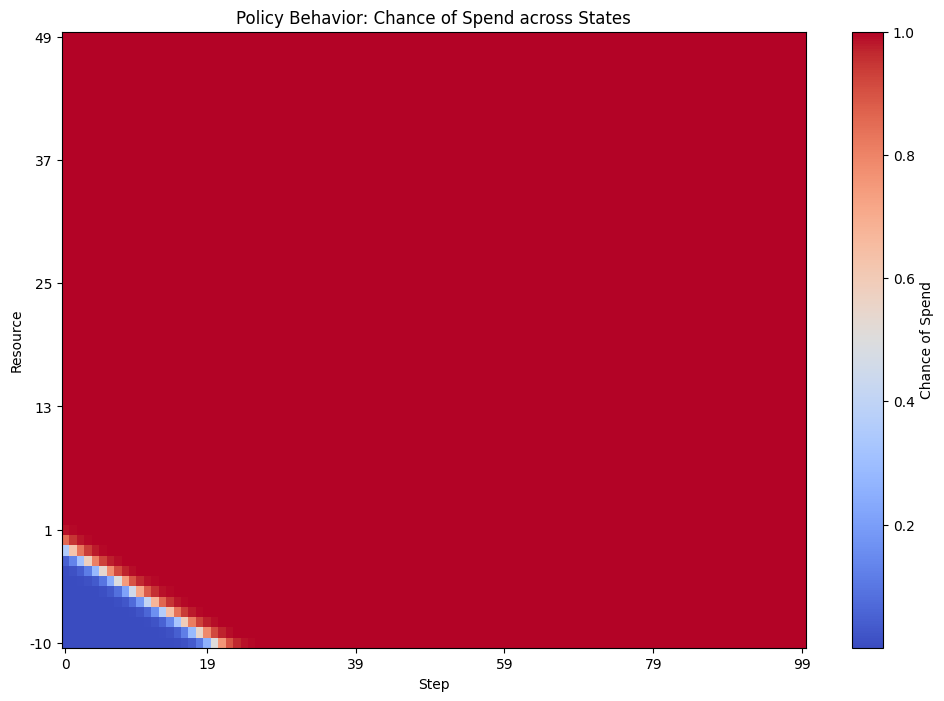

state: [10  0], reward: -1
state: [9 1], reward: 1
state: [10  2], reward: 3
state: [13  3], reward: 0
state: [13  4], reward: -1
state: [12  5], reward: 1
state: [13  6], reward: 3
state: [16  7], reward: 3
state: [19  8], reward: -1
state: [18  9], reward: 1
state: [19 10], reward: 0
state: [19 11], reward: 2
state: [21 12], reward: -1
state: [20 13], reward: -1
state: [19 14], reward: 3
state: [22 15], reward: 0
state: [22 16], reward: 0
state: [22 17], reward: -1
state: [21 18], reward: 2
state: [23 19], reward: 0
state: [23 20], reward: 2
state: [25 21], reward: 1
state: [26 22], reward: 3
state: [29 23], reward: -1
state: [28 24], reward: -1
state: [27 25], reward: -1
state: [26 26], reward: 2
state: [28 27], reward: 0
state: [28 28], reward: 2
state: [30 29], reward: 2
state: [32 30], reward: -1
state: [31 31], reward: -1
state: [30 32], reward: 2
state: [32 33], reward: 3
state: [35 34], reward: -1
state: [34 35], reward: 2
state: [36 36], reward: 0
state: [36 37], reward: 0
st

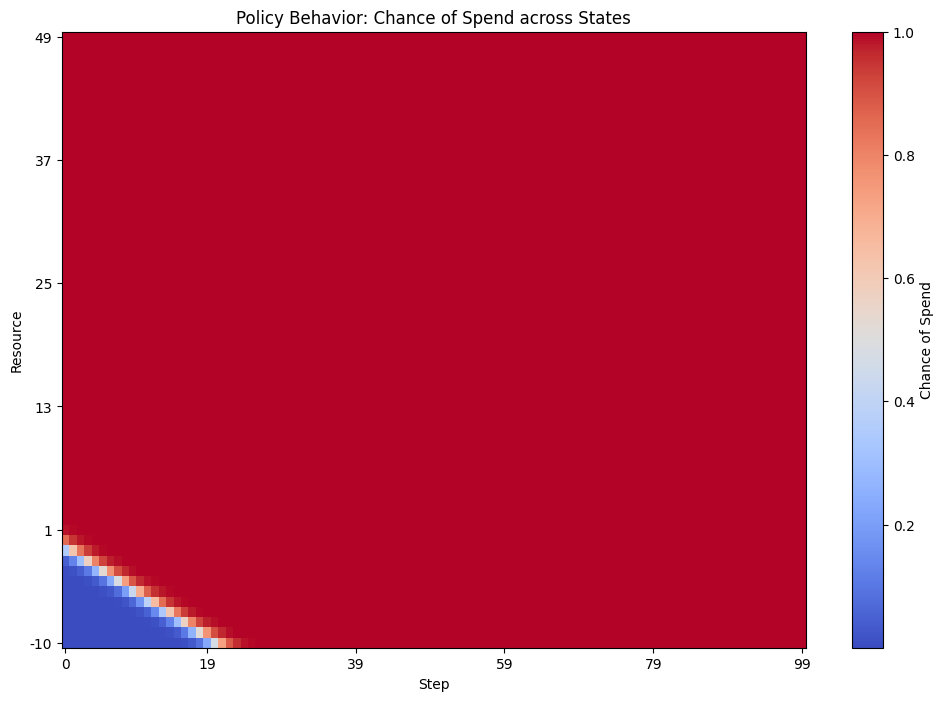

state: [10  0], reward: 1
state: [11  1], reward: 1
state: [12  2], reward: 1
state: [13  3], reward: 2
state: [15  4], reward: 0
state: [15  5], reward: 0
state: [15  6], reward: -1
state: [14  7], reward: 0
state: [14  8], reward: 0
state: [14  9], reward: 3
state: [17 10], reward: -1
state: [16 11], reward: 2
state: [18 12], reward: -1
state: [17 13], reward: -1
state: [16 14], reward: 3
state: [19 15], reward: -1
state: [18 16], reward: 2
state: [20 17], reward: 1
state: [21 18], reward: 3
state: [24 19], reward: 2
state: [26 20], reward: 3
state: [29 21], reward: 0
state: [29 22], reward: 2
state: [31 23], reward: 2
state: [33 24], reward: -1
state: [32 25], reward: 0
state: [32 26], reward: -1
state: [31 27], reward: 3
state: [34 28], reward: -1
state: [33 29], reward: 2
state: [35 30], reward: -1
state: [34 31], reward: 0
state: [34 32], reward: 2
state: [36 33], reward: 0
state: [36 34], reward: 1
state: [37 35], reward: 3
state: [40 36], reward: 1
state: [41 37], reward: 0
sta

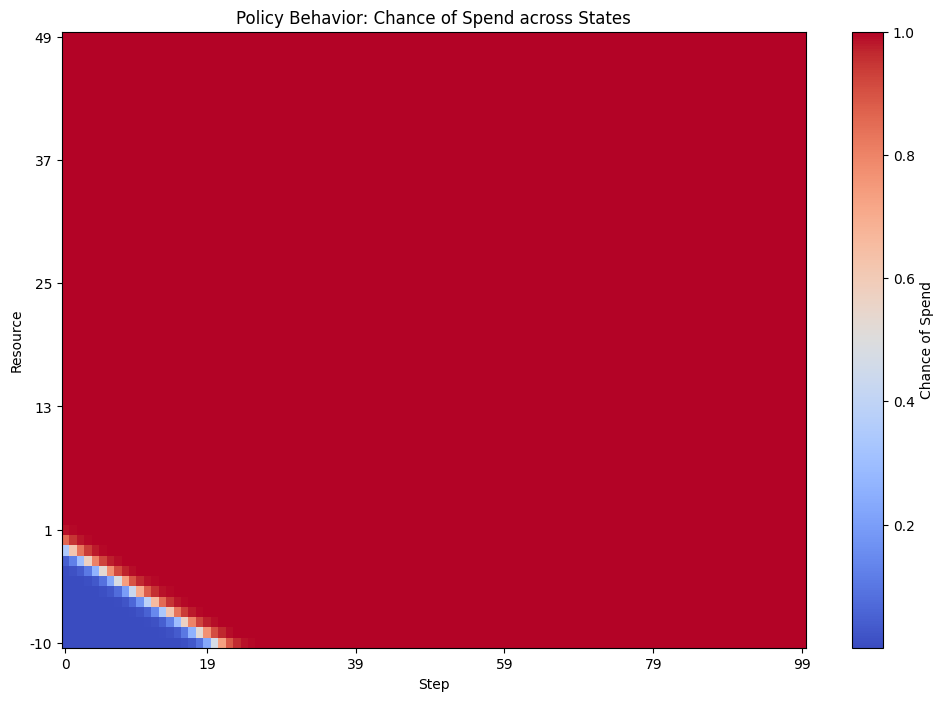

In [107]:
# Train the agent
env = game()
trained_policy = train_policy(env)

In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming HarderResourceGame and trained_policy are defined elsewhere

test_episodes = 100
trained_rewards = []
always_spend_rewards = []
always_save_rewards = []
episode_numbers = []

for episode in range(test_episodes):
    env_trained = game()
    env_spend = game()
    env_save = game()

    state_trained = env_trained.reset()
    state_spend = env_spend.reset()
    state_save = env_save.reset()

    episode_trained_reward = 0
    episode_spend_reward = 0
    episode_save_reward = 0
    
    done = False
    while not done:
        # Trained policy
        state_tensor = torch.FloatTensor(state_trained)
        action_probs = trained_policy(state_tensor)
        action = torch.multinomial(action_probs, num_samples=1).item()
        state_trained, reward_trained, done, _ = env_trained.step(action)

        episode_trained_reward += reward_trained

        # Always spend policy
        state_spend, reward_spend, _, _ = env_spend.step(1)
        episode_spend_reward += reward_spend

        print(reward_spend)

        # Always save policy
        state_save, reward_save, _, _ = env_save.step(0)
       
    print()

    trained_rewards.append(episode_trained_reward)
    always_spend_rewards.append(episode_spend_reward)
    always_save_rewards.append(episode_save_reward)
    episode_numbers.append(episode + 1)

    print(f"Episode {episode + 1}: Trained: {episode_trained_reward:.2f}, "
          f"Always Spend: {episode_spend_reward:.2f}, "
          f"Always Save: {episode_save_reward:.2f}")

print(f"\nAverage Rewards over {test_episodes} episodes:")
print(f"Trained Policy: {np.mean(trained_rewards):.2f}")
print(f"Always Spend: {np.mean(always_spend_rewards):.2f}")
print(f"Always Save: {np.mean(always_save_rewards):.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, trained_rewards, label='Trained Policy')
plt.plot(episode_numbers, always_spend_rewards, label='Always Spend')
plt.plot(episode_numbers, always_save_rewards, label='Always Save')
plt.title('Reward over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

2
-1
-1
5
2
0
-1
15
0
25
52
0
105
32
175
1
108
236
502
620
99
1667
1648
5012
4434
8104
14197
15372
28116
27181
71410
147795
80193
67005
457790
893307
1684097
2701326
4378161
149751
5769378
4187048
734886
1177829
3762267
13004977
11842200
49204100
8597706
11429885
116552994
65056510
45523317
144344485
193690988
297434478
835143661
1580403914
1971790668
5061818432
5819307835
2213222847
3219319588
8421934936
26934678449
53922874881
90149318173
18847147329
215929278393
343774152096
728353533320
1374336594667
983177105379
2252338241497
5434704982628
1575523122628
9774242941352
20627431810897
33625660236992
9345018093749
84710642475411
22149763740260
185010432611731
7337313045812
114029583644407
265360406201733
351372270880290
219933790864819
1259987770424181
226406768049102
1437613654030516
1514848092830584
4833071649257998
3873839242056930
2094622029775364
7700105738989905
11326970761626208
25207288875065626
15720975780891250
23842129197564654

Episode 1: Trained: 100.00, Always Spend: 100

ValueError: high is out of bounds for int64

In [260]:
always_spend_rewards

[-50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50]